In [ ]:
import wave
import pandas as pd
import numpy as np
import math
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

from sklearn.decomposition  import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import scipy
import os
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
#Extract audio and selection data as dataframes
def dataext(sound, selt, en, bugs):

  one, two = scipy.io.wavfile.read(sound,'rb')
  time_col = pd.Series(range(len(two)))
  df = pd.DataFrame({'Time': time_col, 'AudioData': two})
  #df
  time_col, two=None, None
  sel = pd.read_table(selt)

  print('Data extracted successfully')

  print(sel['Species Code'].value_counts())
  if bugs == 'F':
    sel = sel[sel['Species Code'] != 'BUG']
    sel = sel.reset_index()
    #print(sel)

  #Combine frogs into one
  frogs = ['GRTR', 'GRTR1', 'GRTR2', 'GRTR3', 'GRTR4', 'SOLE1', 'SOLE2', 'AMBU', 'SOTO']
  non = ['BEEP', 'BUG', 'CAR', 'CONC1', 'CONC2', 'CONC3', 'FISH', 'GRBH', 'HONK', 'idk', 'IDK', 'MACH', 'OWL', 'PLANE', 'RUN', 'SIREN', 'THUD', 'TRAF', 'TRAIN', 'WALK', 'WATER', 'WIND']
  nonf = ['BIRD', 'BEEP', 'BUG', 'CAR', 'CONC1', 'CONC2', 'CONC3', 'FISH', 'GRBH', 'HONK', 'idk', 'IDK', 'MACH', 'OWL', 'PLANE', 'RUN', 'SIREN', 'THUD', 'TRAF', 'TRAIN', 'WALK', 'WATER', 'WIND']

  if en=='frogs':
    sel['Species Code'].replace(frogs, "FROG", inplace=True)

  #Combine frogs into one, birds into one, others into one
  elif en=='bin':
    sel['Species Code'].replace(frogs, "FROG", inplace=True)
    sel['Species Code'].replace(non, "E", inplace=True)

  #Combine all others into one, to identify frog species
  elif en=='species':
    sel['Species Code'].replace(nonf, "E", inplace=True)

  else:
    print("Please input a valid argument for en")

  print("Data extraction complete")
  return df, sel

def enc(c):

  codes = ['AMBU','BEEP', 'BIRD', 'BUG', 'CAR', 'CONC1', 'CONC2', 'CONC3', 'FISH', 'GRBH', 'GRTR', 'GRTR1', 'GRTR2', 'GRTR3', 'GRTR4', 'HONK', 'idk', 'IDK', 'MACH', 'OWL', 'PLANE', 'RUN', 'SIREN', 'SOLE1', 'SOLE2', 'SOTO', 'THUD', 'TRAF', 'TRAIN', 'WALK', 'WATER', 'WIND']
  frogs = ['GRTR1', 'GRTR2', 'GRTR3', 'GRTR4', 'SOLE1', 'SOLE2', 'AMBU', 'SOTO', 'E', 'GRTR']

  labe = LabelEncoder()

  if c == "frogs":
    frog = ["FROG", 'BEEP', 'BIRD', 'BUG', 'CAR', 'CONC1', 'CONC2', 'CONC3', 'FISH', 'GRBH', 'HONK', 'idk', 'IDK', 'MACH', 'OWL', 'PLANE', 'RUN', 'SIREN', 'THUD', 'TRAF', 'TRAIN', 'WALK', 'WATER', 'WIND']
    labe.fit(frog)
  elif c == 'bin':
    bin = ['FROG', 'BIRD', 'E']
    labe.fit(bin)
  elif c == "species":
    labe.fit(frogs)
  else:
    labe.fit(codes)

  return labe

#Full=False balances the dataset better for training, =Frogs for species classification, =True for test set
def dataprep(df, sel, window, labe, full):

  df['AudioData'][:((len(df['AudioData'])//48000)-4)*48000].values.shape
  if window == 1:
    audio = df['AudioData'][:(len(df['AudioData'])//48000)*48000].values.reshape(len(df['AudioData'])//48000, 48000)
  else:
    audio = df['AudioData'][:((len(df['AudioData'])//48000)-window+1)*48000].values.reshape(len(df['AudioData'])//(48000*window), 48000*window)

  print('Windowing complete')


  ne = labe.transform(sel['Species Code'])
  final = sel.merge(pd.Series(ne, name='Code'), left_index=True, right_index=True)

  #adding columns for label encoding
  audio = np.hstack((audio, np.ones([audio.shape[0], 1], audio.dtype)))

  #For unmarked seconds
  for ones in range(0, len(audio)):
    audio[ones][len(audio[0])-1] = len(labe.classes_)

  print("Audio shape:", audio.shape)

  #For labels
  for n in range(0, len(sel['Selection'])):
    for t in range(math.floor(sel['Begin Time (s)'][n]/window), math.ceil(sel['End Time (s)'][n]/window)):
      if t >= ((len(df['AudioData'])//48000)/window-1) or labe.inverse_transform([final['Code'][n]])==['BUG'] or labe.inverse_transform([final['Code'][n]])==['WIND']:
        continue

      audio[t, len(audio[0])-1] = final['Code'][n]

  final=None

  print("Audio shape:", audio.shape)
  y = audio[:,-1]
  x = audio[:,0:-1]

  if full==False:
      x, y = adj(x, y, window, labe, "b")
  if full=='Frogs':
      x, y = adj(x, y, window, labe, "f")

  print('Data preparation complete')
  #print(y)
  return x, y


def adj(x, y, window, labe, t):

    xt = np.array([])
    yt = np.array([])
    c=0
    if t=='f':
        for k in range(0, len(x)):
            if y[k]!=len(labe.classes_):
                c+=1
        for k in range(0, len(x)):
            if y[k]==len(labe.classes_) or labe.inverse_transform(y[k])=='E':
                if random.choice(range(0,c*4))==0:
                    xt = np.append(xt, x[k])
                    yt = np.append(yt, y[k])
            else:
                xt = np.append(xt, [x[k]])
                yt = np.append(yt, y[k])

    else:
        for k in range(0, len(x)):
            if y[k]!=len(labe.classes_):
                c+=1
        for k in range(0, len(x)):
            if y[k]==len(labe.classes_) or labe.inverse_transform([y[k]])=='BUG' or labe.inverse_transform([y[k]])=='WIND':
                if random.choice(range(0,c))==0:
                    xt = np.append(xt, x[k])
                    yt = np.append(yt, y[k])
            else:
                xt = np.append(xt, [x[k]])
                yt = np.append(yt, y[k])

    length = 48000*window
    xt = xt[:(len(xt)//(length))*length].reshape(len(xt)//(length), (length))
    #print(len(yt))
    yt = yt[:len(xt)]

    #Debugging
    print(len(yt))
    unique, counts = np.unique(yt, return_counts=True)
    print(dict(zip(unique, counts)))
    return xt, yt

In [ ]:
directory = os.getcwd()+'\Traindataf'
os.chdir(directory)
sf = []
for filename in os.listdir():
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        sf.append(f)
#sf

In [ ]:
d1, s1 = dataext(sf[0], sf[0][:36]+'Selection Tables'+sf[0][-25:-3]+'Table.1.selections.txt', 'frogs', 'F')
labe = enc("frogs")
x_train, y_train = dataprep(d1, s1, 5, labe, False)
d1, s1 = None, None

pca=PCA(n_components=.999)
x_train = pca.fit_transform(x_train)

learning_rate = tf.Variable(0.00001, trainable=False)

#Neural Network for identifying frog calls
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(x_train[0]), activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(.1, input_shape=(2,)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(33, activation=tf.nn.relu),
  tf.keras.layers.Dense(len(labe.classes_)+1, activation=tf.nn.softmax)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train = x_train
act = y_train
for t in range(1, len(sf)):
    #try:
    print(t)
    d1, s1 = dataext(sf[t], sf[t][:36]+'Selection Tables'+sf[t][-25:-3]+'Table.1.selections.txt', 'frogs', 'F')
    x_train, y_train = dataprep(d1, s1, 5, labe, True)

    try:
        x_train = pca.transform(x_train)
        train = np.concatenate((train, x_train))
        act = np.concatenate((act, y_train))
    except:
        print('well shit')
        print(t)
print(train.shape)

Data extracted successfully
Species Code
SOLE1    59
SOLE2    19
TRAF     17
AMBU     11
BIRD     10
GRTR1     5
HONK      1
GRTR4     1
WATER     1
GRTR3     1
OWL       1
BUG       1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
472
{1.0: 200, 8.0: 151, 10.0: 1, 13.0: 3, 18.0: 114, 21.0: 2, 24.0: 1}
Data preparation complete
1
Data extracted successfully
Species Code
SOTO     166
AMBU      14
HONK      14
WIND       5
BUG        4
GRTR2      3
TRAF       3
SOLE1      1
MACH       1
PLANE      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
2
Data extracted successfully
Species Code
AMBU     65
BIRD     58
SOTO     30
TRAF     17
WIND      7
BEEP      4
GRTR3     3
GRTR1     2
MACH      2
SOLE2     1
OWL       1
WALK      1
BUG       1
Name: count, dtype: int64
Data extraction complete
Windowing complete
A

In [ ]:
directory = r'C:\Users\verno\Desktop\Y3S1\CSC 432\Reducedwav'
#directory = os.getcwd()+'\Traindataf'
os.chdir(directory)
sf2 = []
for filename in os.listdir():
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        sf2.append(f)

#train = x_train
#act = y_train
for t in range(1, len(sf2)):
    print(t)
    d1, s1 = dataext(sf2[t], sf2[t][:36]+'Selection Tables'+sf2[t][-29:-7]+'Table.1.selections.txt', 'frogs', 'F')
    x_train, y_train = dataprep(d1, s1, 5, labe, True)

    x_train = pca.transform(x_train)
    train = np.concatenate((train, x_train))
    act = np.concatenate((act, y_train))

print(train.shape)
model.fit(train, act, epochs=20, verbose=1)

1
Data extracted successfully
Species Code
SOTO     166
AMBU      14
HONK      14
WIND       5
BUG        4
GRTR2      3
TRAF       3
SOLE1      1
MACH       1
PLANE      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
2
Data extracted successfully
Species Code
AMBU     65
BIRD     58
SOTO     30
TRAF     17
WIND      7
BEEP      4
GRTR3     3
GRTR1     2
MACH      2
SOLE2     1
OWL       1
WALK      1
BUG       1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
3
Data extracted successfully
Species Code
AMBU     97
SOLE2    50
SOLE1    44
BUG       6
SIREN     5
TRAF      4
GRTR2     3
BIRD      2
GRTR3     2
IDK       2
HONK      2
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
4
D

In [ ]:
directory = r'C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles'
os.chdir(directory)
sft = []
for filename in os.listdir():
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        sft.append(f)
#sft

In [ ]:
window = 5
name = 29
d1, s1 = dataext(sft[name], sft[name][:36]+'Selection Tables'+sft[name][-25:-3]+'Table.1.selections.txt', 'frogs', 'F')
x_train, y_train = dataprep(d1, s1, window, labe, True)
x_train = pca.transform(x_train)
print(sft[name])
model.evaluate(x_train, y_train)

Data extracted successfully
Species Code
GRTR3    43
GRTR2     7
BUG       1
TRAF      1
GRBH      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles\GFL1_20230717_030000.wav
23/23 [==============================] - 0s 2ms/step - loss: 26.2001 - accuracy: 0.4103


[26.200069427490234, 0.4102920591831207]

In [ ]:
sf[5][:36]+'Selection Tables'+sf[5][-25:-3]+'Table.1.selections.txt'

'C:\\Users\\verno\\Desktop\\Y3S1\\CSC 432\\Selection Tables\\GFL1_20230715_010000.Table.1.selections.txt'

In [ ]:
window = 5
d1, s1 = dataext(sf[5], sf[5][:36]+'Selection Tables'+sf[5][-25:-3]+'Table.1.selections.txt', 'frogs', 'F')
x_train, y_train = dataprep(d1, s1, window, labe, True)
x_train = pca.transform(x_train)
print(sft[20])
model.evaluate(x_train, y_train)

Data extracted successfully
Species Code
GRTR1    5
BUG      3
GRTR3    2
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles\GFL1_20230715_010000.wav
23/23 [==============================] - 0s 3ms/step - loss: 6.0007 - accuracy: 0.6759


[6.00065803527832, 0.6759387850761414]

In [ ]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
conf_mx=confusion_matrix(y_train, y_pred)
print(conf_mx)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  2   0  43   0   0   0   0   0   0  19]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 14   5 173   1   1  15   1   1   1 443]]


In [ ]:
#print(len(y_pred))
#df = pd.DataFrame(y_pred)
#y_pred

In [ ]:
try:
    y_pred1 = model.predict(x_train[[160]])
    y_pred1 = np.argmax(y_pred1, axis=1)
    print(y_pred1)
    print(labe.inverse_transform([y_pred1[0]]))
    labe.inverse_transform([0])
except:
    print()

[24]



In [ ]:
d1, s1 = dataext(sft[29], sft[29][:36]+'Selection Tables'+sft[29][-25:-3]+'Table.1.selections.txt', 'frogs', 'F')
x, y = dataprep(d1, s1, 1, labe, True)
sft[29]

Data extracted successfully
Species Code
GRTR3    43
GRTR2     7
BUG       1
TRAF      1
GRBH      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (3599, 48001)
Audio shape: (3599, 48001)
Data preparation complete


'C:\\Users\\verno\\Desktop\\Y3S1\\CSC 432\\Soundfiles\\GFL1_20230717_030000.wav'

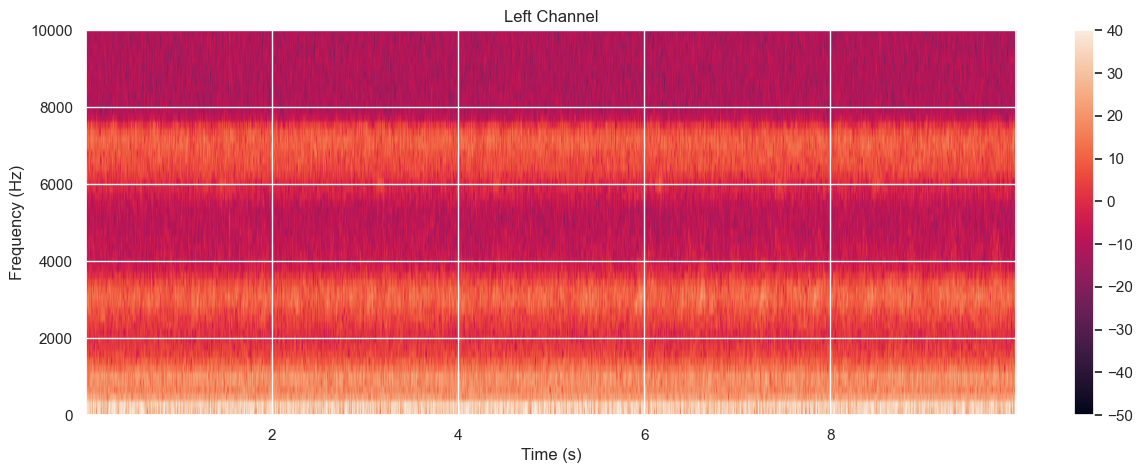

In [ ]:
t = 396
plt.figure(figsize=(15, 5))
plt.specgram(d1['AudioData'][(t-1)*window*48000:(t+1)*window*48000], Fs=48000, vmin=-50, vmax=40)
plt.axis(ymin=0, ymax=10000)
plt.title('Left Channel')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
#plt.xlim(0, t_audio)
plt.colorbar()
#plt.xticks(np.arange(len(a)), np.arange(1, len(a)+1))
plt.show()

Data extracted successfully
Species Code
AMBU     65
BIRD     58
SOTO     30
TRAF     17
WIND      7
BEEP      4
GRTR3     3
GRTR1     2
MACH      2
SOLE2     1
OWL       1
WALK      1
BUG       1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (3599, 48001)
Audio shape: (3599, 48001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Reducedwav\GFL1_20230615_075958.red.wav


C:\Users\verno\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


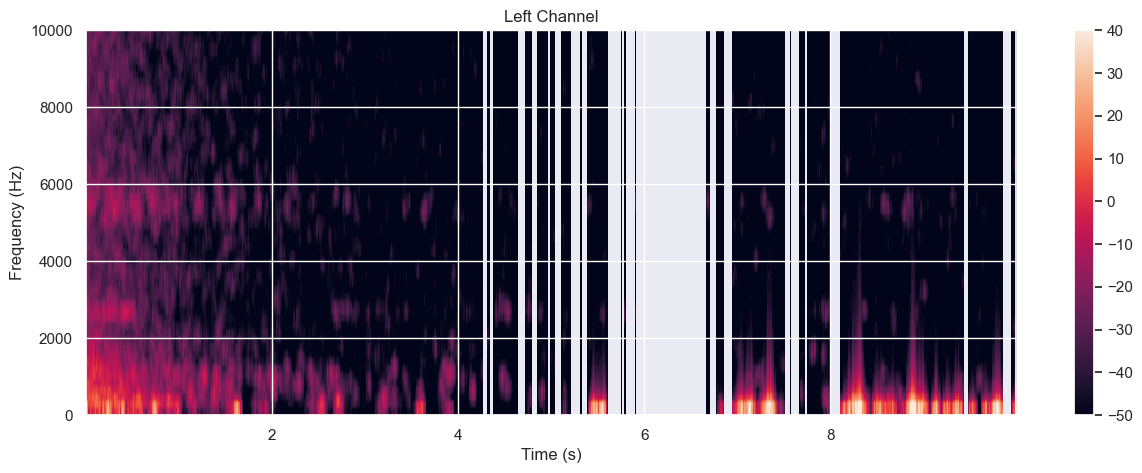

In [ ]:
d1, s1 = dataext(sf2[2], sf2[2][:36]+'Selection Tables'+sf2[2][-29:-7]+'Table.1.selections.txt', 'frogs', 'F')
x, y = dataprep(d1, s1, 1, labe, True)
print(sf2[2])

t = 1
plt.figure(figsize=(15, 5))
plt.specgram(d1['AudioData'][(t-1)*window*48000:(t+1)*window*48000], Fs=48000, vmin=-50, vmax=40)
plt.axis(ymin=0, ymax=10000)
plt.title('Left Channel')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
#plt.xlim(0, t_audio)
plt.colorbar()
#plt.xticks(np.arange(len(a)), np.arange(1, len(a)+1))
plt.show()

In [ ]:
d1, s1 = dataext(sf[0], sf[0][:36]+'Selection Tables'+sf[0][-25:-3]+'Table.1.selections.txt', 'species', 'F')
labes = enc("species")
x_train, y_train = dataprep(d1, s1, 5, labes, True)
d1, s1 = None, None
pca2=PCA(n_components=.999)
x_train = pca2.fit_transform(x_train)

learning_rate = tf.Variable(0.00001, trainable=False)


spec_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(x_train[0]), activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(.1, input_shape=(2,)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dense(len(labe.classes_)+1, activation=tf.nn.softmax)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

spec_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train = x_train
act = y_train
for t in range(1, len(sf)):

    print(t)
    d1, s1 = dataext(sf[t], sf[t][:36]+'Selection Tables'+sf[t][-25:-3]+'Table.1.selections.txt', 'species', 'F')

    x_train, y_train = dataprep(d1, s1, 5, labes, True)
    x_train = pca2.transform(x_train)
    train = np.concatenate((train, x_train))
    act = np.concatenate((act, y_train))

for t in range(0, len(sf2)):
    print(t)
    d1, s1 = dataext(sf2[t], sf2[t][:36]+'Selection Tables'+sf2[t][-29:-7]+'Table.1.selections.txt', 'species', 'F')
    x_train, y_train = dataprep(d1, s1, 5, labes, True)

    x_train = pca2.transform(x_train)
    train = np.concatenate((train, x_train))
    act = np.concatenate((act, y_train))

print(train.shape)
spec_model.fit(train, act, epochs=20, verbose=1)

Data extracted successfully
Species Code
SOLE1    59
SOLE2    19
TRAF     17
AMBU     11
BIRD     10
GRTR1     5
HONK      1
GRTR4     1
WATER     1
GRTR3     1
OWL       1
BUG       1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
1
Data extracted successfully
Species Code
SOTO     166
AMBU      14
HONK      14
WIND       5
BUG        4
GRTR2      3
TRAF       3
SOLE1      1
MACH       1
PLANE      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
2
Data extracted successfully
Species Code
AMBU     65
BIRD     58
SOTO     30
TRAF     17
WIND      7
BEEP      4
GRTR3     3
GRTR1     2
MACH      2
SOLE2     1
OWL       1
WALK      1
BUG       1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation co

495/495 [==============================] - 3s 6ms/step - loss: 27.4059 - accuracy: 0.2489
Epoch 14/20
495/495 [==============================] - 3s 6ms/step - loss: 21.4525 - accuracy: 0.2199
Epoch 15/20
495/495 [==============================] - 3s 6ms/step - loss: 12.4869 - accuracy: 0.1972
Epoch 16/20
495/495 [==============================] - 3s 7ms/step - loss: 5.7454 - accuracy: 0.2430
Epoch 17/20
495/495 [==============================] - 3s 7ms/step - loss: 3.6836 - accuracy: 0.2918
Epoch 18/20
495/495 [==============================] - 3s 6ms/step - loss: 3.2596 - accuracy: 0.3102
Epoch 19/20
495/495 [==============================] - 3s 7ms/step - loss: 3.0667 - accuracy: 0.3140
Epoch 20/20
495/495 [==============================] - 3s 6ms/step - loss: 2.9410 - accuracy: 0.3240


In [ ]:
directory = r'C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles'
os.chdir(directory)
sft = []
for filename in os.listdir():
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        sft.append(f)

In [ ]:
window = 5
d1, s1 = dataext(sft[29], sft[29][:36]+'Selection Tables'+sft[29][-25:-3]+'Table.1.selections.txt', 'frogs', 'F')
x_train, y_train = dataprep(d1, s1, window, labe, True)
x_train = pca.transform(x_train)
print(sft[20])
model.evaluate(x_train, y_train)

Data extracted successfully
Species Code
GRTR3    43
GRTR2     7
BUG       1
TRAF      1
GRBH      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles\GFL1_20230715_010000.wav
23/23 [==============================] - 0s 3ms/step - loss: 26.2001 - accuracy: 0.4103


[26.200069427490234, 0.4102920591831207]

In [ ]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
conf_mx=confusion_matrix(y_train, y_pred)
print(conf_mx)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 21   9   4   1   1 248   0  18   1   2   3   5   5   1 289]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  7   2   0   0   0  45   0   6   0   1   0   0   2   0  47]]


In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
#percentages
norm_conf_mx = conf_mx / row_sums
print(pd.DataFrame(100*np.round(norm_conf_mx,3)))

     0    1    2    3    4      5    6    7    8    9    10   11   12   13  \
0   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5   3.5  1.5  0.7  0.2  0.2   40.8  0.0  3.0  0.2  0.3  0.5  0.8  0.8  0.2   
6   0.0  0.0  0.0  0.0  0.0  100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
8   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
9   NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
10  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
11  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN

C:\Users\verno\AppData\Local\Temp\ipykernel_36640\196896821.py:3: RuntimeWarning: invalid value encountered in true_divide
  norm_conf_mx = conf_mx / row_sums


In [ ]:
print(len(y_pred))
df = pd.DataFrame(y_pred)
y_pred

719


array([ 8,  8, 24,  8,  8, 24, 24, 24,  1,  8,  1,  8,  8,  8, 24,  8, 24,
        8,  8,  8, 24, 24, 24,  8,  8,  8, 24, 24, 24, 24,  8, 24, 24,  8,
        8, 24, 24,  8,  8,  8,  8, 24,  5, 24, 24, 24, 24,  8, 24, 24, 24,
       13, 24, 24,  8,  8, 24,  8, 24, 24, 24,  8,  8,  8, 24, 24,  8, 24,
       24, 24, 24, 24,  8, 19, 24, 24, 17,  8, 24,  8,  8,  8, 24, 24, 24,
        8, 24, 24, 24, 24, 24, 24,  8,  8, 24, 24, 24,  8, 13,  8, 24, 24,
        8, 24, 24,  8, 24, 24, 24,  8,  8,  8,  8, 24, 24, 24, 24,  8,  8,
        8, 24, 13,  1,  8, 24, 24,  8, 24,  8, 13,  8,  8, 24,  8,  8, 24,
        8, 24,  8,  8,  8, 24,  8, 24,  1, 24, 24, 24,  8, 24, 24, 24,  8,
       24,  8,  8,  8,  8,  1,  8, 24, 24, 24, 18, 24,  8, 24,  8,  8, 24,
        1,  8,  8,  8,  8,  8,  8, 24,  8, 24,  8, 24,  8,  8, 24,  8, 21,
       24,  8,  8,  8, 24,  8, 24,  8, 24,  2, 24,  1,  8,  8,  8, 17, 24,
        8,  8, 24, 24,  8, 24,  8,  8,  8,  8, 24, 24,  8,  8, 24, 24, 24,
       24,  8, 24,  1,  8

In [ ]:
y_train

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [ ]:
labe.inverse_transform([[8]])

C:\Users\verno\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['FROG'], dtype='<U5')

In [ ]:
d1, s1 = dataext(sft[29], sft[29][:36]+'Selection Tables'+sft[29][-25:-3]+'Table.1.selections.txt', 'species', 'F')
x_train, ya = dataprep(d1, s1, window, labes, True)
x_train = pca2.transform(x_train)
print(sft[20])

Data extracted successfully
Species Code
GRTR3    43
GRTR2     7
BUG       1
TRAF      1
GRBH      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles\GFL1_20230715_010000.wav


In [ ]:
ilist = []
flist = []
for f in range(0,len(y_pred)):
    try:
        if labe.inverse_transform([y_pred[f]])=='FROG':
            ilist.append(f)
            flist.append(ya[f])
    except:
        continue
dlist = []
for i in ilist:
    dlist.append(x_train[i])
x_t = np.array(dlist)
y_t = np.array(flist)
spec_model.evaluate(x_t, y_t)

10/10 [==============================] - 0s 3ms/step - loss: 3.3691 - accuracy: 0.1531


[3.3690922260284424, 0.15306122601032257]

In [ ]:
y_t

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  1,  5,  5, 10, 10,  5,  5,  4,  4, 10,  5, 10,  5,  5,  5,
        5,  5,  5,  5,  5,  5, 10,  5,  5,  5,  5,  5,  5,  5, 10, 10,  5,
        5, 10, 10,  5,  5,  5, 10,  5, 10,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5, 10,  5,  5, 10, 10, 10, 10,  5,  5,  5,  5,  5,
        5, 10, 10, 10, 10

In [ ]:
labes.inverse_transform([[4]])

C:\Users\verno\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['GRTR2'], dtype='<U5')

In [ ]:
from scipy.io import wavfile
import noisereduce as nr
# load data

rate, data = wavfile.read(sft[29])
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
    #f = open(sf[i][:-25]+'red.wav', "x")
fn = sft[29][:-3]+'red.wav'
wavfile.write(fn, rate, reduced_noise)

In [ ]:
window = 5

d1, s1 = dataext(fn, fn[:36]+'Selection Tables'+fn[-29:-7]+'Table.1.selections.txt', 'frogs', 'F')
x_train, y_train = dataprep(d1, s1, window, labe, True)
x_train = pca.transform(x_train)
print(sft[20])
model.evaluate(x_train, y_train)

Data extracted successfully
Species Code
GRTR3    43
GRTR2     7
BUG       1
TRAF      1
GRBH      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles\GFL1_20230715_010000.wav
23/23 [==============================] - 0s 4ms/step - loss: 1.4983 - accuracy: 0.3713


[1.4982590675354004, 0.3713490962982178]

In [ ]:
d1, s1 = dataext(fn, fn[:36]+'Selection Tables'+fn[-29:-7]+'Table.1.selections.txt', 'species', 'F')
x_train, ya = dataprep(d1, s1, window, labes, True)
x_train = pca2.transform(x_train)
print(sft[20])
ilist = []
flist = []
for f in range(0,len(y_pred)):
    try:
        if labe.inverse_transform([y_pred[f]])=='FROG':
            ilist.append(f)
            flist.append(ya[f])
    except:
        continue
dlist = []
for i in ilist:
    dlist.append(x_train[i])
x_t = np.array(dlist)
y_t = np.array(flist)
spec_model.evaluate(x_t, y_t)

Data extracted successfully
Species Code
GRTR3    43
GRTR2     7
BUG       1
TRAF      1
GRBH      1
Name: count, dtype: int64
Data extraction complete
Windowing complete
Audio shape: (719, 240001)
Audio shape: (719, 240001)
Data preparation complete
C:\Users\verno\Desktop\Y3S1\CSC 432\Soundfiles\GFL1_20230715_010000.wav
10/10 [==============================] - 0s 5ms/step - loss: 3.8672 - accuracy: 0.1599


[3.8672232627868652, 0.15986394882202148]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 468)               0         
_________________________________________________________________
dense (Dense)                (None, 468)               219492    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               240128    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1

In [ ]:
spec_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 710)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 710)               504810    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               364032    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 256)              